In [2]:
import os
import random
from PIL import Image
from tabulate import tabulate

In [3]:
import tqdm

# Reading the database

You can download the database here:

- [https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip](https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip)
- [ipfs://QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM](ipfs://QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM)
- [https://ipfs.prgm.dev/ipfs/QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM](https://ipfs.prgm.dev/ipfs/QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM)

Shasum (.zip): `2576b647185063db2aa3dc2f5622908e99f3cd40` 

In [4]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

## Database header
The first 30 bytes of the database are reserved for a header which currently contains **three** 4-byte int: 
1. The number of machines that are undecided because they went beyond the time limit (`47,176,870` steps)
2. The number of machines that are undecided because they went beyond the space limit (`12,289` memory cells)
3. The total number of undecided machines (sum of above)

In [5]:
def get_header(machine_db_path):
    with open(machine_db_path, "rb") as f:
        return f.read(30)

In [6]:
header = get_header(DB_PATH)
undecided_time, undecided_space, undecided_total = int.from_bytes(header[:4],byteorder='big'),int.from_bytes(header[4:8],byteorder='big'),int.from_bytes(header[8:12],byteorder='big')
print(undecided_time, undecided_space, undecided_total, header[12])

14322029 74342035 88664064 1


## Database core

The core of the database is `88,664,064` machines descriptions which are each written on 30 bytes.

In [7]:
n = os.path.getsize(DB_PATH)
print((n)/30-1)

88664064.0


In [8]:
def get_machine_i(machine_db_path, i, db_has_header=True):
    with open(machine_db_path, "rb") as f:
        c = 1 if db_has_header else 0
        f.seek(30*(i+c))
        return f.read(30)

In [9]:
def ithl(i):
    return chr(ord("A")+i)

def g(move):
    if move == 0:
        return "R"
    return "L"

def pptm(machine, return_repr=False):
    headers = ["s","0","1"]
    table = []
    
    for i in range(5):
        row = [ithl(i)]
        for j in range(2):
            write = machine[6*i+3*j] 
            move = machine[6*i+3*j+1] 
            goto = machine[6*i+3*j+2]-1
            
            if goto == -1:
                row.append("???")
                continue
                
            row.append(f"{write}{g(move)}{ithl(goto)}")
        table.append(row)
    
    if not return_repr:
        print(tabulate(table,headers=headers))
    else:
        return tabulate(table,headers=headers)

In [10]:
pptm(get_machine_i(DB_PATH,0,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  ???
B    0RC  ???
C    0RD  ???
D    0RE  ???
E    0LD  ???


In [11]:
pptm(get_machine_i(DB_PATH,10,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  ???
B    0RC  ???
C    0RD  ???
D    0RE  0LD
E    1LC  ???


In [12]:
pptm(get_machine_i(DB_PATH,4888230,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  0RD
B    0RC  0LE
C    1RD  1RA
D    1LA  1LC
E    ???  1LD


# Simulating and visualising machines

In [13]:
def step(machine, curr_state, curr_pos, tape):
    if not curr_pos in tape:
        tape[curr_pos] = 0
    
    write = machine[curr_state*6 + 3*tape[curr_pos]] 
    move = machine[curr_state*6 + 3*tape[curr_pos] + 1] 
    goto = machine[curr_state*6 + 3*tape[curr_pos] + 2] - 1

    if goto == -1:
        return None, None
    
    tape[curr_pos] = write
    next_pos = curr_pos  + (-1 if move else 1)
    return goto, next_pos

In [14]:
def simulate(machine, time_limit = 1000, mini =-10, maxi=-10):
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    while curr_state != None and curr_time < time_limit:
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        if curr_state is not None:
            pprinttape(tape, curr_state, curr_pos, mini=mini, maxi=maxi)
        else:
            print("HALT")
        curr_time += 1
        

In [15]:
def tm_trace_to_image(machine, width=900, height=1000, origin=0.5, show_head_direction=False):
    img = Image.new('RGB', (width, height), color = 'black')
    pixels = img.load()
    
    
    tape = {}
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    
    for row in range(1,height):
        last_pos = curr_pos
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        
        if curr_state is None: #halt
            return img
        
        for col in range(width):
            pos = col-width*(origin)
            
            if pos in tape:
                pixels[col,row] = (255,255,255) if tape[pos] == 1 else (0,0,0)
                #pixels[col,row-1] = colors[curr_state-1]
                
            if pos == curr_pos and show_head_direction:
                pixels[col,row] = (255,0,0) if curr_pos > last_pos else (0,255,0) 
                
                
    #img = zoom_at(img,*zoom)
    return img

In [16]:
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)

## BB(5) champion

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [17]:
def repr_to_bytes(rep):
    to_rep = bytearray()
    for a in rep:
        to_rep.append(a)
    return to_rep

R, L = 0, 1
bb5_champion_repr = [1, R, 2, 1, L, 3,
		1, R, 3, 1, R, 2,
		1, R, 4, 0, L, 5,
		1, L, 1, 1, L, 4,
		1, R, 6, 0, L, 1]
bb5_champion = repr_to_bytes(bb5_champion_repr)
pptm(bb5_champion)

s    0    1
---  ---  ---
A    1RB  1LC
B    1RC  1RB
C    1RD  0LE
D    1LA  1LD
E    1RF  0LA


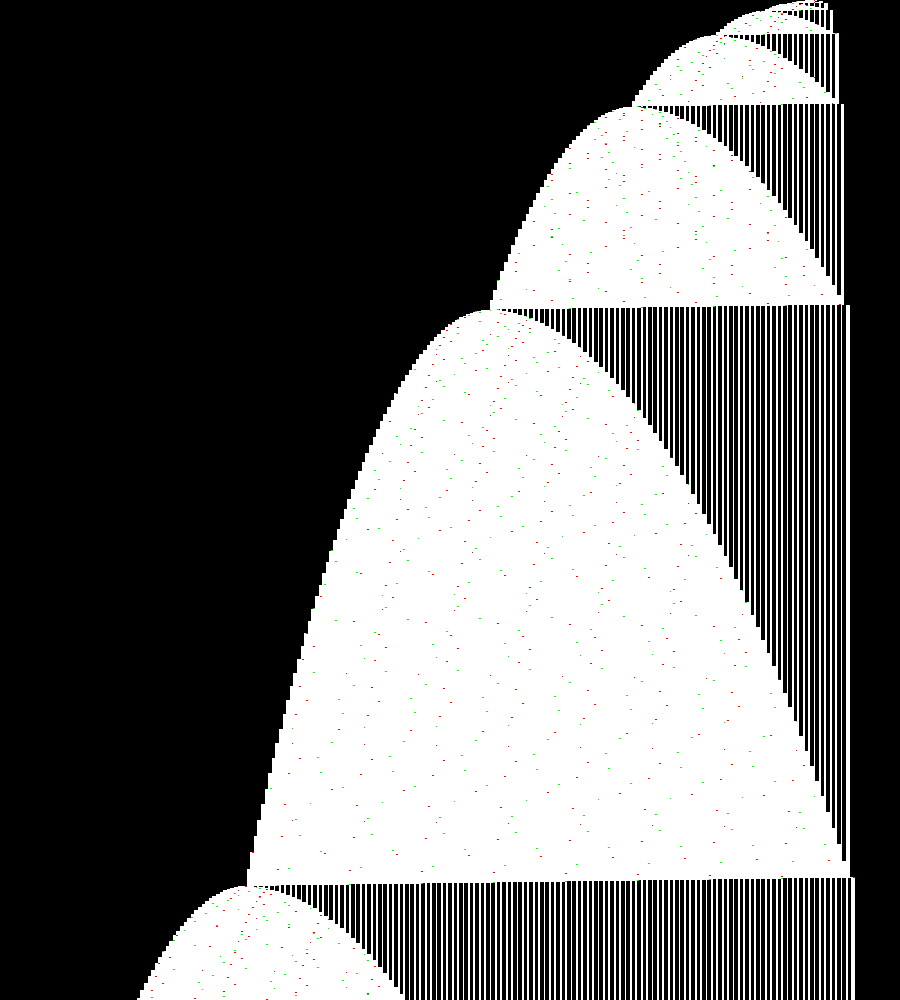

In [18]:
img = tm_trace_to_image(bb5_champion, origin=0.9, width=500, height=40000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Other Halting machines

These were find while running [https://github.com/bbchallenge/bbchallenge-seed](https://github.com/bbchallenge/bbchallenge-seed).

### 40899 steps

In [19]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, C,
		0, R, C, 0, 0, 0,
		1, R, D, 0, R, E,
		1, L, E, 0, R, A,
		0, L, A, 0, L, E]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 40899 steps.")

s    0    1
---  ---  ---
A    1RB  0LC
B    0RC  ???
C    1RD  0RE
D    1LE  0RA
E    0LA  0LE
Halts after 40899 steps.


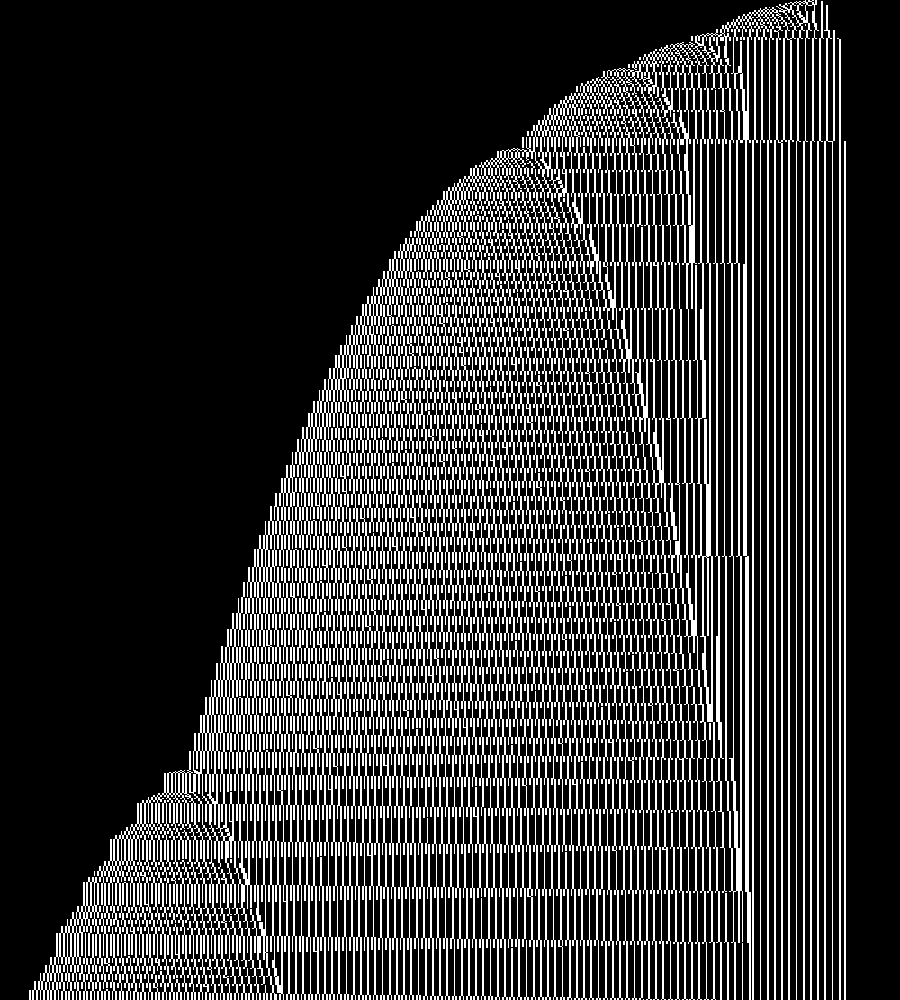

In [20]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=40899).resize((900,1000), Image.NEAREST)
img

### 20739 Steps

In [21]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, A,
		0, R, C, 1, R, D,
		1, L, C, 1, L, A,
		1, R, A, 1, R, E,
		0, 0, 0, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 20739 steps.")

s    0    1
---  ---  ---
A    1RB  0LA
B    0RC  1RD
C    1LC  1LA
D    1RA  1RE
E    ???  0RB
Halts after 20739 steps.


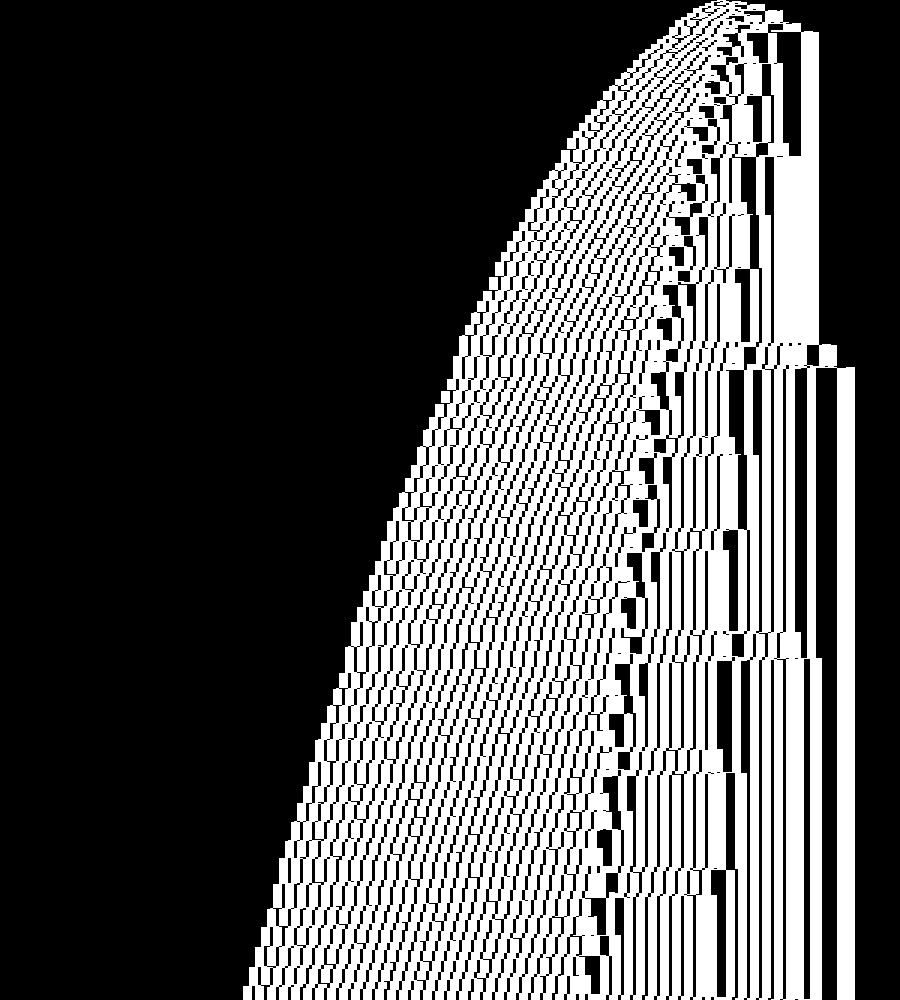

In [22]:
img = tm_trace_to_image(m, origin=0.8, width=300, height=20739).resize((900,1000), Image.NEAREST)
img

### 5309 Steps

In [23]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, R, C, 1, L, E,
		1, L, B, 1, R, D,
		1, R, C, 0, L, A,
		0, 0, 0, 1, L, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 5309 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0RC  1LE
C    1LB  1RD
D    1RC  0LA
E    ???  1LB
Halts after 5309 steps.


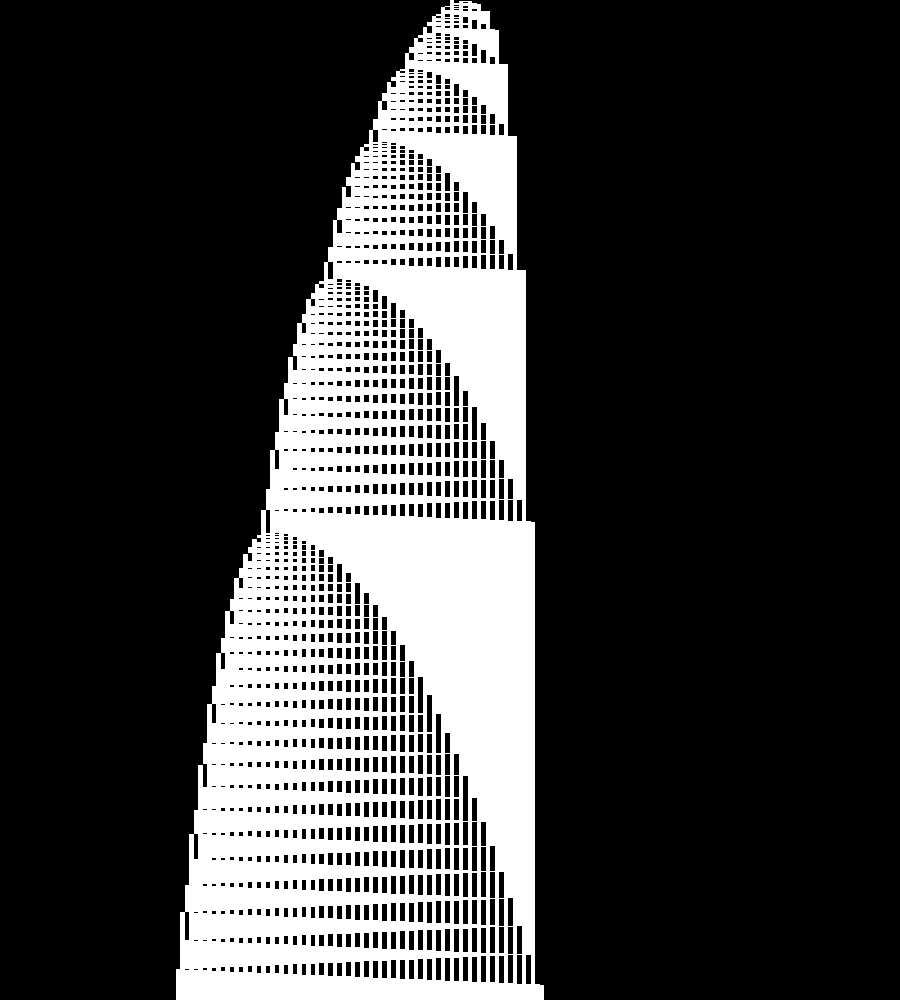

In [24]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=5309).resize((900,1000), Image.NEAREST)
img

### 6987 steps

In [25]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, R, D,
		0, R, C, 1, R, C,
		1, L, A, 0, L, A,
		1, L, C, A, L, E,
		0, 0, 0, 0, L, D]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 6987 steps.")

s    0    1
---  ---  ---
A    1RB  1RD
B    0RC  1RC
C    1LA  0LA
D    1LC  1LE
E    ???  0LD
Halts after 6987 steps.


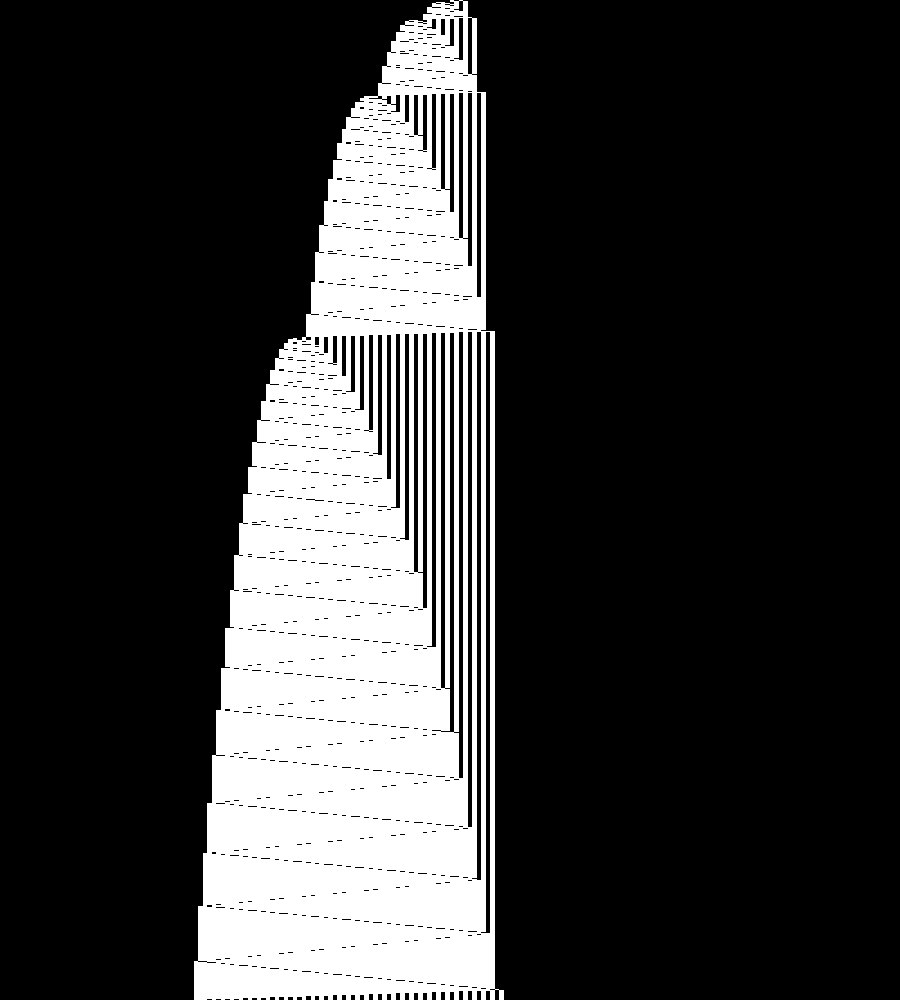

In [26]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=6987).resize((900,1000), Image.NEAREST)
img

### 22335 steps

In [27]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, L, B, 1, R, C,
		1, L, D, 0, L, E,
		1, R, E, 1, L, C,
		0, 0, 0, 0, R, A]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 22335 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0LB  1RC
C    1LD  0LE
D    1RE  1LC
E    ???  0RA
Halts after 22335 steps.


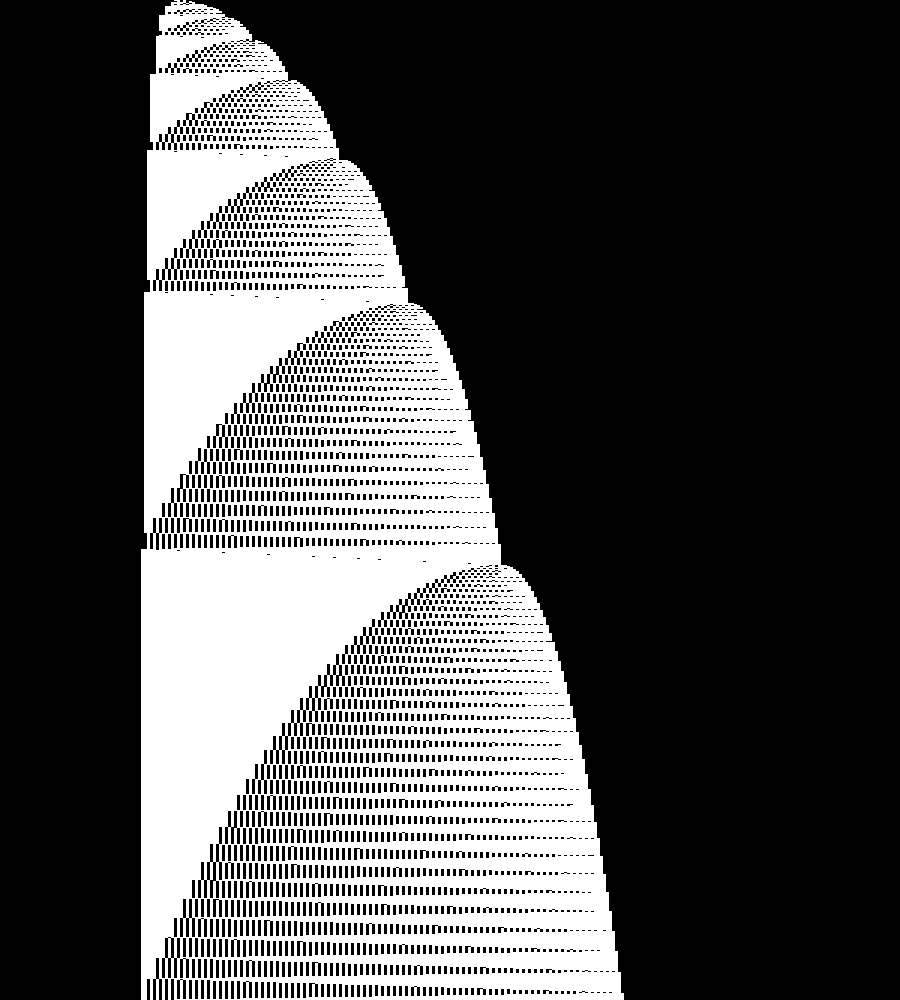

In [28]:
img = tm_trace_to_image(m, origin=0.2, width=300, height=22335).resize((900,1000), Image.NEAREST)
img

### 2133492 steps

In [29]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, C,
		0, L, A, 0, L, D,
		1, L, A, 0, 0, 0,
		1, L, B, 1, R, E,
		0, R, D, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 2133492 steps.")

s    0    1
---  ---  ---
A    1RB  1LC
B    0LA  0LD
C    1LA  ???
D    1LB  1RE
E    0RD  0RB
Halts after 2133492 steps.


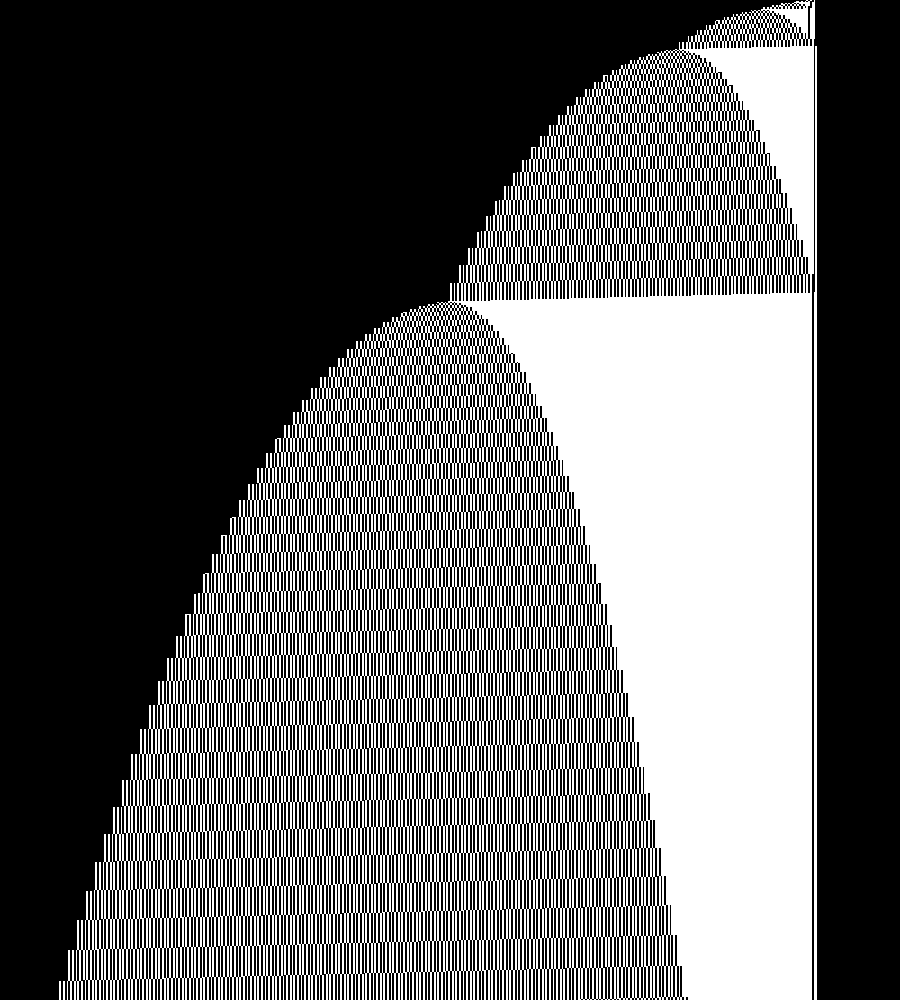

In [30]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=22335).resize((900,1000), Image.NEAREST)
img

## "Chaotic" machine

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [31]:
R, L = 0, 1
chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		1, L, 0, 0, L, 3]
chaotic_machine = repr_to_bytes(chaotic_machine_rep)
pptm(chaotic_machine)

s    0    1
---  ---  ---
A    1LB  1RB
B    1RC  0LE
C    0RD  0LA
D    1LA  0RD
E    ???  0LC


In [32]:
R, L = 1, 0
sym_chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		0, 0, 0, 0, L, 3]
sym_chaotic_machine = repr_to_bytes(sym_chaotic_machine_rep)
pptm(sym_chaotic_machine) 
print("This is machine n = 76708232")

s    0    1
---  ---  ---
A    1RB  1LB
B    1LC  0RE
C    0LD  0RA
D    1RA  0LD
E    ???  0RC
This is machine n = 76708232


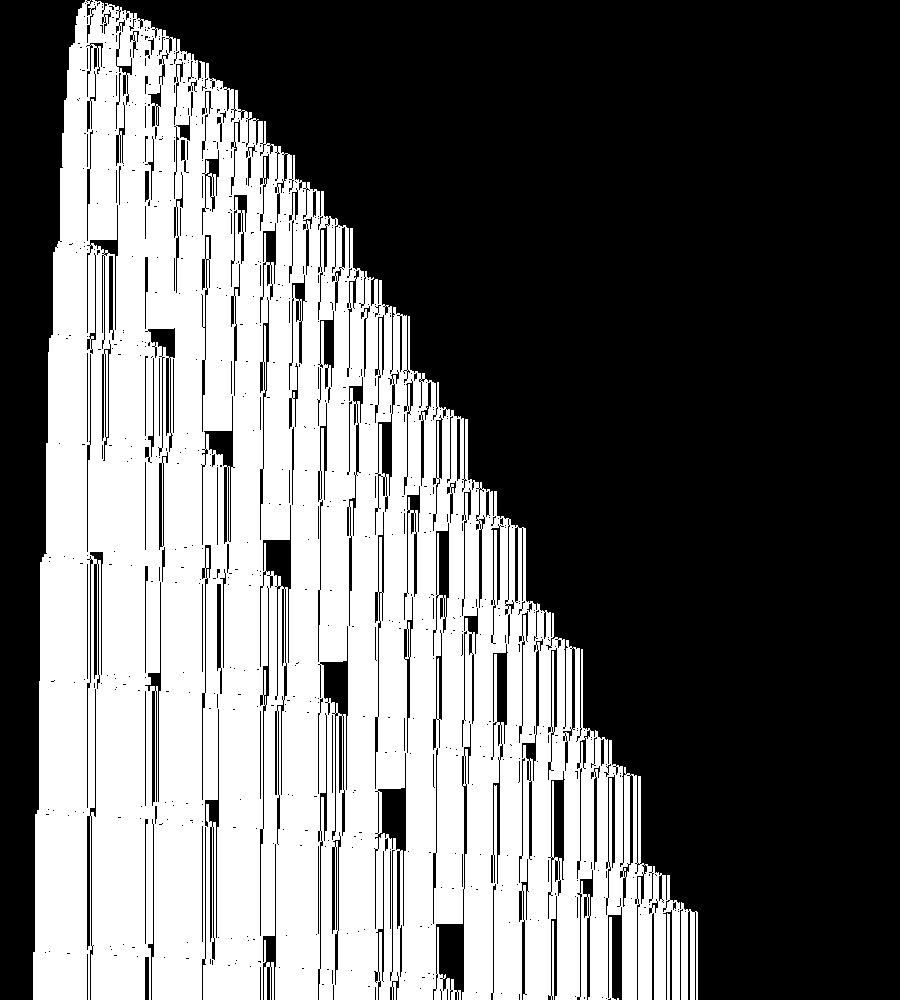

In [33]:
img = tm_trace_to_image(sym_chaotic_machine, origin=0.1, width=1000, height=100000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## "Complex counter"

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [34]:
R, L = 0, 1
complex_counter_rep = [1, L, 2, 1, R, 1,
		0, R, 1, 0, L, 3,
		0, R, 3, 1, L, 4,
		1, L, 5, 0, R, 1,
		0, L, 2, 0, 0, 0]
complex_counter = repr_to_bytes(complex_counter_rep)
pptm(complex_counter)

s    0    1
---  ---  ---
A    1LB  1RA
B    0RA  0LC
C    0RC  1LD
D    1LE  0RA
E    0LB  ???


In [35]:
L, R = 0, 1
complex_counter_rep_sym = [1, L, 2, 1, R, 1,
		0, R, 1, 0, L, 3,
		0, R, 3, 1, L, 4,
		1, L, 5, 0, R, 1,
		0, L, 2, 0, 0, 0]
complex_counter_sym = repr_to_bytes(complex_counter_rep_sym)
pptm(complex_counter_sym)
R, L = 0, 1

s    0    1
---  ---  ---
A    1RB  1LA
B    0LA  0RC
C    0LC  1RD
D    1RE  0LA
E    0RB  ???


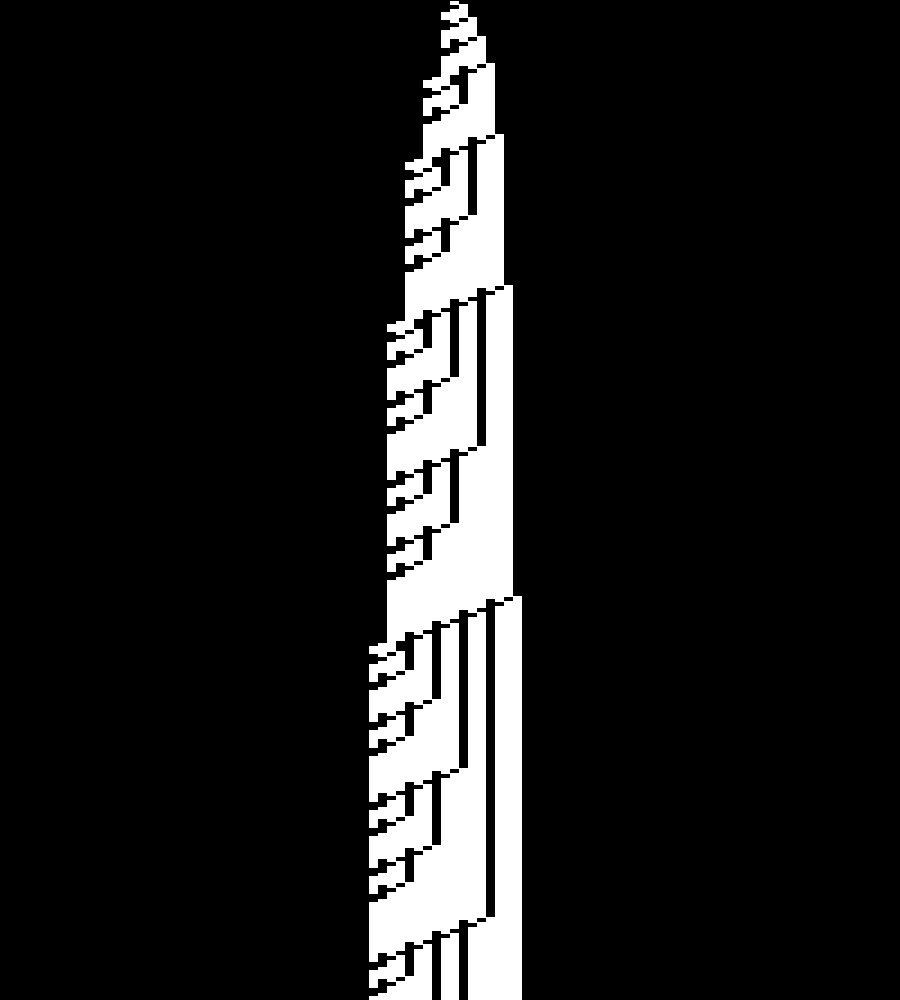

In [36]:
img = tm_trace_to_image(complex_counter, origin=0.5, width=100, height=1000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Random machine

In [37]:
n_history = []

1687575
s    0    1
---  ---  ---
A    1RB  ???
B    1RC  0RC
C    1LB  0LD
D    0RC  1LE
E    0RD  1LC


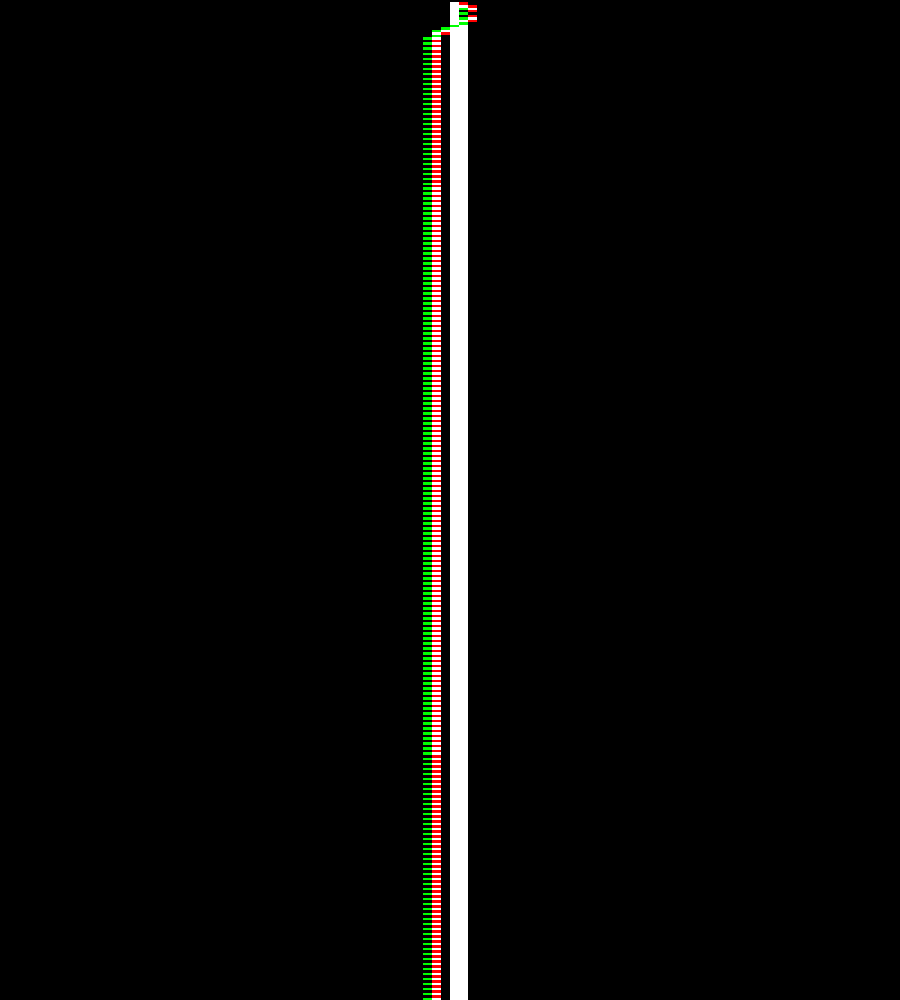

In [38]:
n = random.randint(0,undecided_total-1)
n_history.append(n)

print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Undecided Index

Available for download: https://github.com/bbchallenge/bbchallenge-undecided-index/

In [39]:
UNDECIDED_INDEX_PATH= "bb5_undecided_index"#_with_heuristics"
UNDECIDED_FILE_SIZE = os.path.getsize(UNDECIDED_INDEX_PATH)
UNDECIDED_FILE_SIZE

14302160

In [41]:
undecided_index = []
with open(UNDECIDED_INDEX_PATH, "rb") as f:
    for i in range(UNDECIDED_FILE_SIZE//4):
        chunk = f.read(4)
        undecided_index.append(int.from_bytes(chunk, byteorder="big"))

In [42]:
undecided_time_index = []
undecided_space_index = []
for i in undecided_index:
    if i < undecided_time:
        undecided_time_index.append(i)
    else:
        undecided_space_index.append(i)
print(len(undecided_time_index), len(undecided_space_index))

3092791 482749


In [43]:
def is_sub_machine(m,m1):
    """ m sub machine of m1"""
    for i in range(len(m)//3):
        if m[3*i+2] == 0:
            continue
        for j in range(3):
            if m[3*i+j] != m1[3*i+j]:
                return False
    return True

# Looking for 2 machines of Marxen and Buntrock

The following code checks if a given machine description is in the index. We are interesting in finding the ID of the "chaotic machine" and the "complex counter" described in Marxen and Buntrock, 1990. We find IDs `76708232` for the chaotic machine and `10936909` for the complex counter.

In [44]:
def getMachineID(m, indexToLookOutFrom, printSubMachines=False):
    for i in tqdm.tqdm(indexToLookOutFrom):
        m2 = get_machine_i(DB_PATH,i)
        if m2 == m:
            return i
        if is_sub_machine(m2,m) and printSubMachines:
            print(i)
            pptm(m2)
    print("Not found")
    return None

In [45]:
pptm(sym_chaotic_machine)

s    0    1
---  ---  ---
A    1RB  1LB
B    1LC  0RE
C    0LD  0RA
D    1RA  0LD
E    ???  0RC


In [46]:
getMachineID(sym_chaotic_machine,undecided_space_index)

 86%|████████▌ | 413015/482749 [00:09<00:01, 41619.63it/s]


76708232

In [47]:
getMachineID(complex_counter_sym,undecided_time_index)

 74%|███████▍  | 2290819/3092791 [00:29<00:10, 77556.88it/s]


10936909

# Random Undecided Machine

In [48]:
n_history = []

64250591


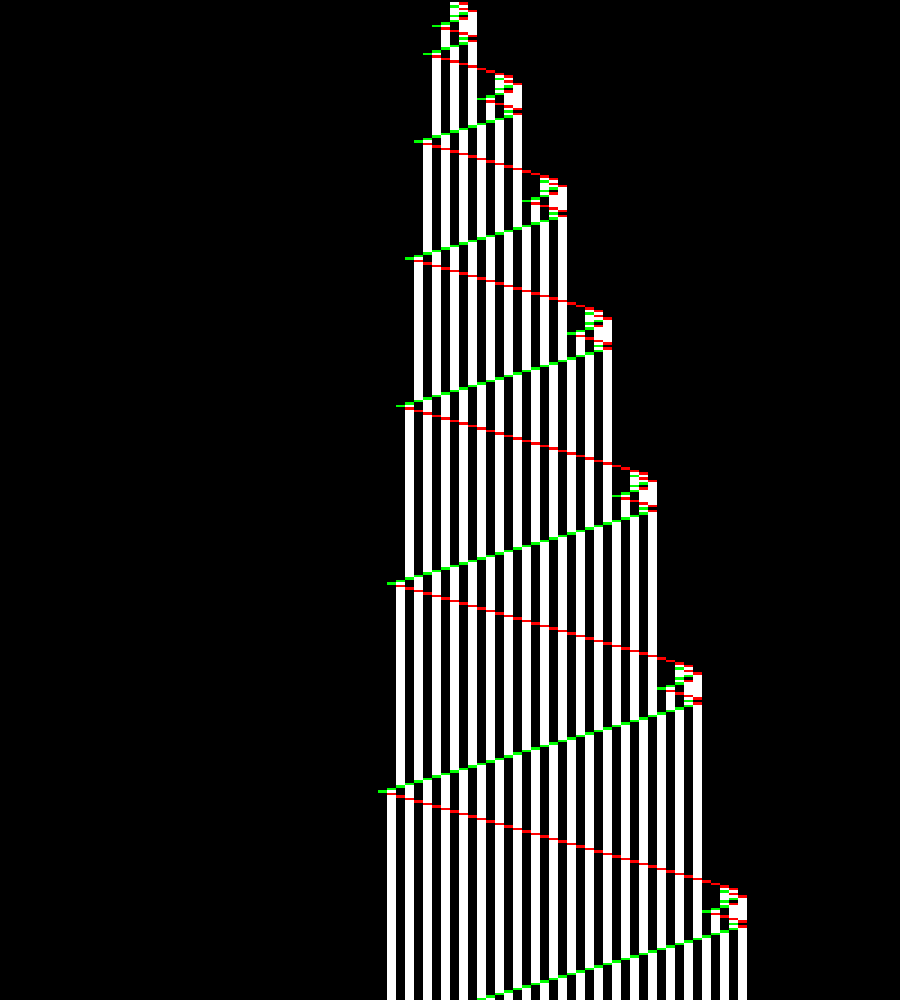

In [49]:
n = random.choice(undecided_index)
n_history.append(n)
print(n)
#pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## List of random undecided machines for speedy lookin

3694175


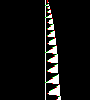

8037931


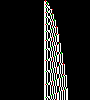

6347866


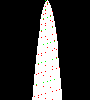

253541


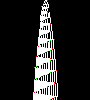

2848396


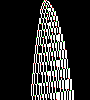

10625450


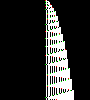

9608034


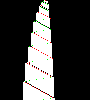

5743174


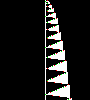

12765329


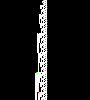

671453


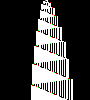

8041442


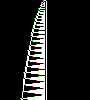

3395625


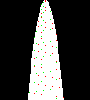

4772311


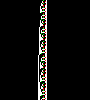

13755404


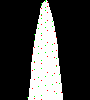

2481229


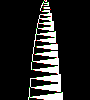

4997834


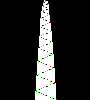

11085083


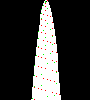

11647197


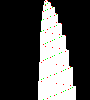

5346926


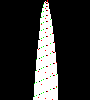

2202438


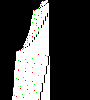

78735590


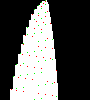

60243139


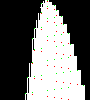

2162972


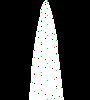

81187362


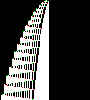

5001937


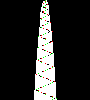

12289703


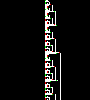

6531399


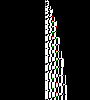

3778078


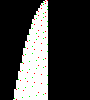

5943137


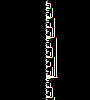

8032656


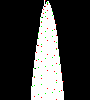

13811746


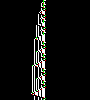

1898203


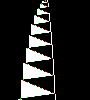

2688380


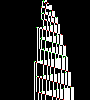

6483875


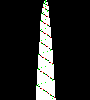

641151


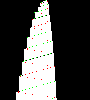

10633757


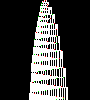

39454650


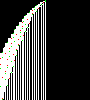

508105


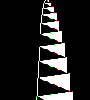

13106437


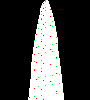

2839314


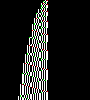

954852


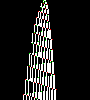

7902218


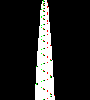

13842183


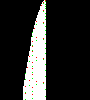

12513892


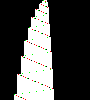

11484372


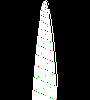

6593264


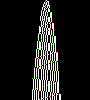

74623694


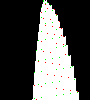

5491980


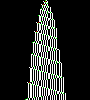

7645930


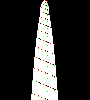

7391593


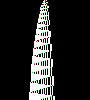

2402612


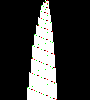

12245449


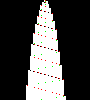

11407199


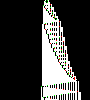

130074


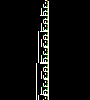

7800810


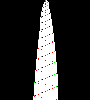

82216900


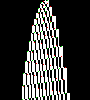

61916043


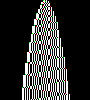

3864097


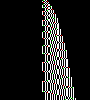

45441630


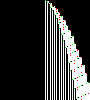

71876937


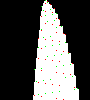

1845067


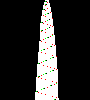

2154466


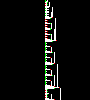

6629752


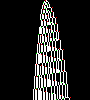

11286321


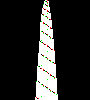

5129333


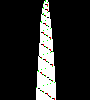

10082656


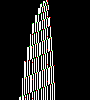

967623


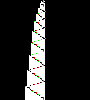

82081647


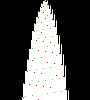

2378869


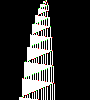

5426820


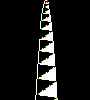

5143324


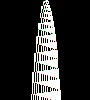

3215241


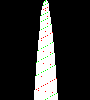

4142888


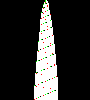

7694009


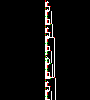

34806331


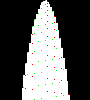

10154376


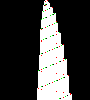

5038657


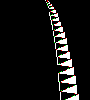

7353869


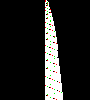

13582594


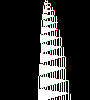

592079


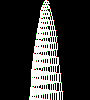

7143450


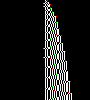

11790166


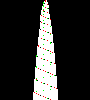

13123102


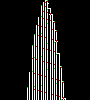

3313439


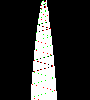

2638265


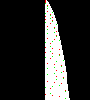

12581072


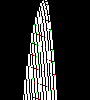

71624525


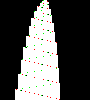

1162132


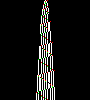

2884670


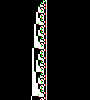

9810602


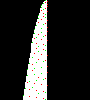

29579501


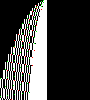

3069986


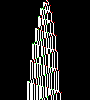

10727771


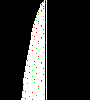

1843959


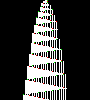

60376548


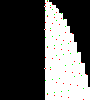

9802844


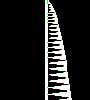

2507797


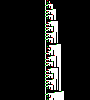

11821491


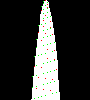

3775085


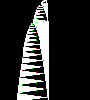

247097


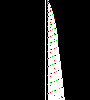

1427537


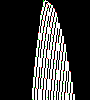

3869805


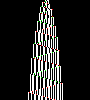

13225492


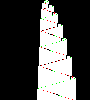

4211335


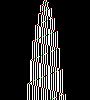

7453181


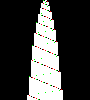

3150326


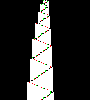

6241816


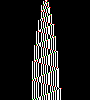

14123185


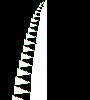

2400070


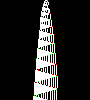

565611


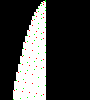

40311


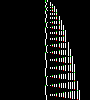

2246123


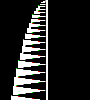

12992587


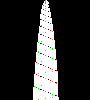

5943834


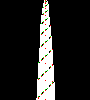

12331616


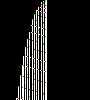

12778415


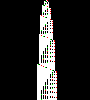

6727163


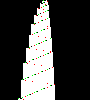

11907563


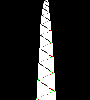

10882180


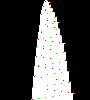

6684874


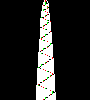

3738601


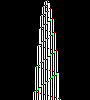

10785558


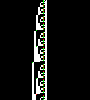

11891061


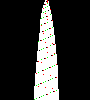

81611777


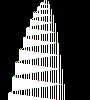

31664980


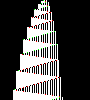

11288027


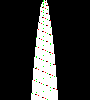

8232701


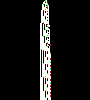

8006344


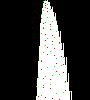

4665920


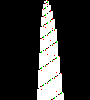

4414915


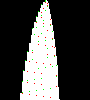

59668349


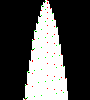

11917581


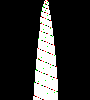

7578952


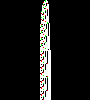

9924534


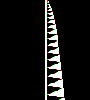

1745678


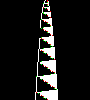

13143468


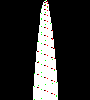

5401893


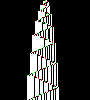

12812487


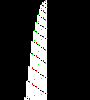

13452726


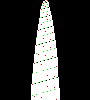

5523711


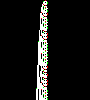

5951524


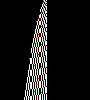

4547662


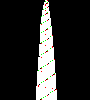

6829837


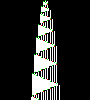

6345871


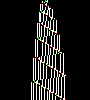

6896254


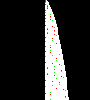

6381394


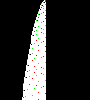

12585462


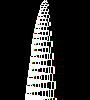

6089036


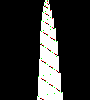

12234232


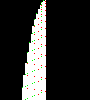

5909277


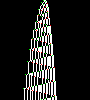

74373855


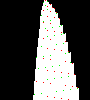

8749844


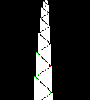

3809764


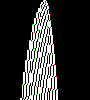

12212776


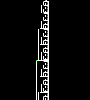

141936


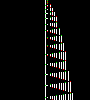

8316739


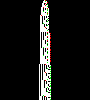

6363421


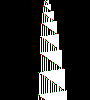

1822582


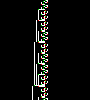

491340


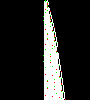

2430129


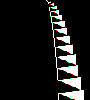

10632459


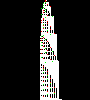

11273353


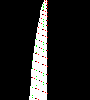

4636675


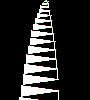

50961298


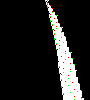

43022156


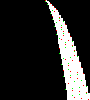

10115256


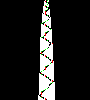

73030877


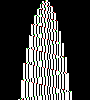

6415800


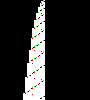

6305419


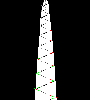

9644354


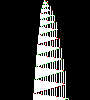

10097927


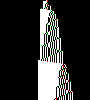

26446471


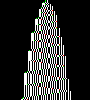

8161384


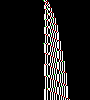

10857642


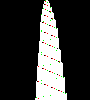

3292081


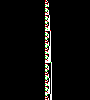

5957690


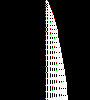

1773695


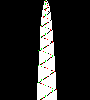

4724062


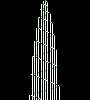

24646938


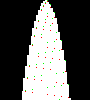

4714176


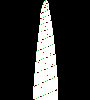

9163238


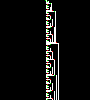

77815367


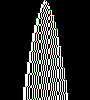

13805969


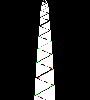

10039200


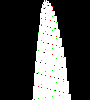

9341857


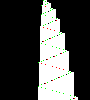

216076


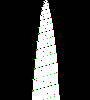

1873923


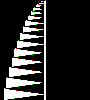

5327359


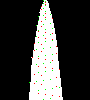

11000658


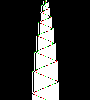

5741872


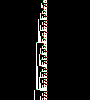

10033839


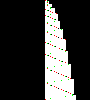

5002950


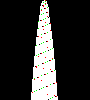

5512395


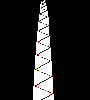

32988037


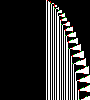

2599356


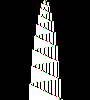

9917614


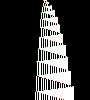

3034879


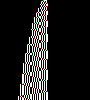

11208850


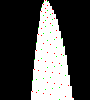

53235320


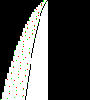

14032392


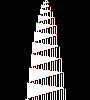

In [50]:
for _ in range(200):
    n = random.choice(undecided_index)
    print(n)
    #pptm(get_machine_i(DB_PATH,n))
    img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=800, show_head_direction=True).resize((90,100), Image.NEAREST)
    display(img)

### Temporary machine under scrutiny

7410754
s    0    1
---  ---  ---
A    1RB  0LD
B    1LC  1RC
C    1LA  0RC
D    ???  0LE
E    0RB  1LD


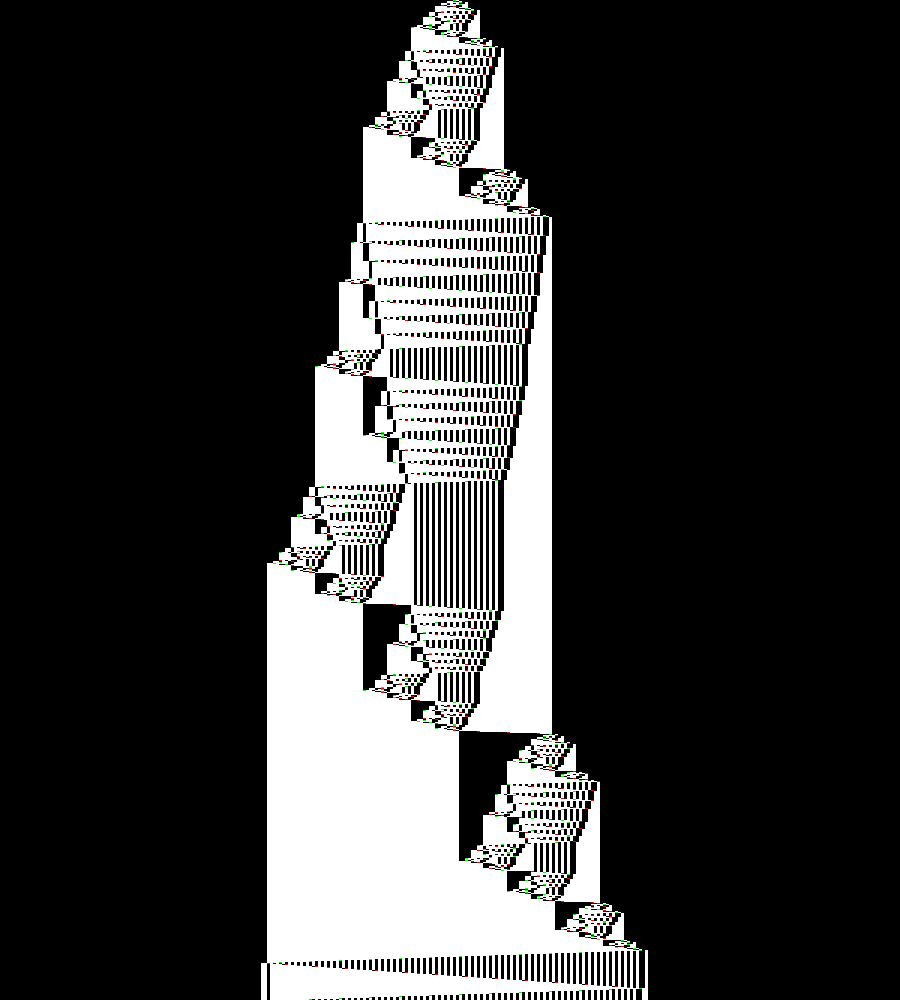

In [51]:
n = 7410754
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=300, height=10000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Zoology

## Cyclers

**Update 28/01/22**. 11 229 238 cyclers were decided (among machines that exceeded time limit) thanks to this decider: [https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-cyclers](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-cyclers).

11636047
s    0    1
---  ---  ---
A    1RB  1LB
B    1RC  1RC
C    1LA  0RD
D    1LC  0LE
E    1RD  ???


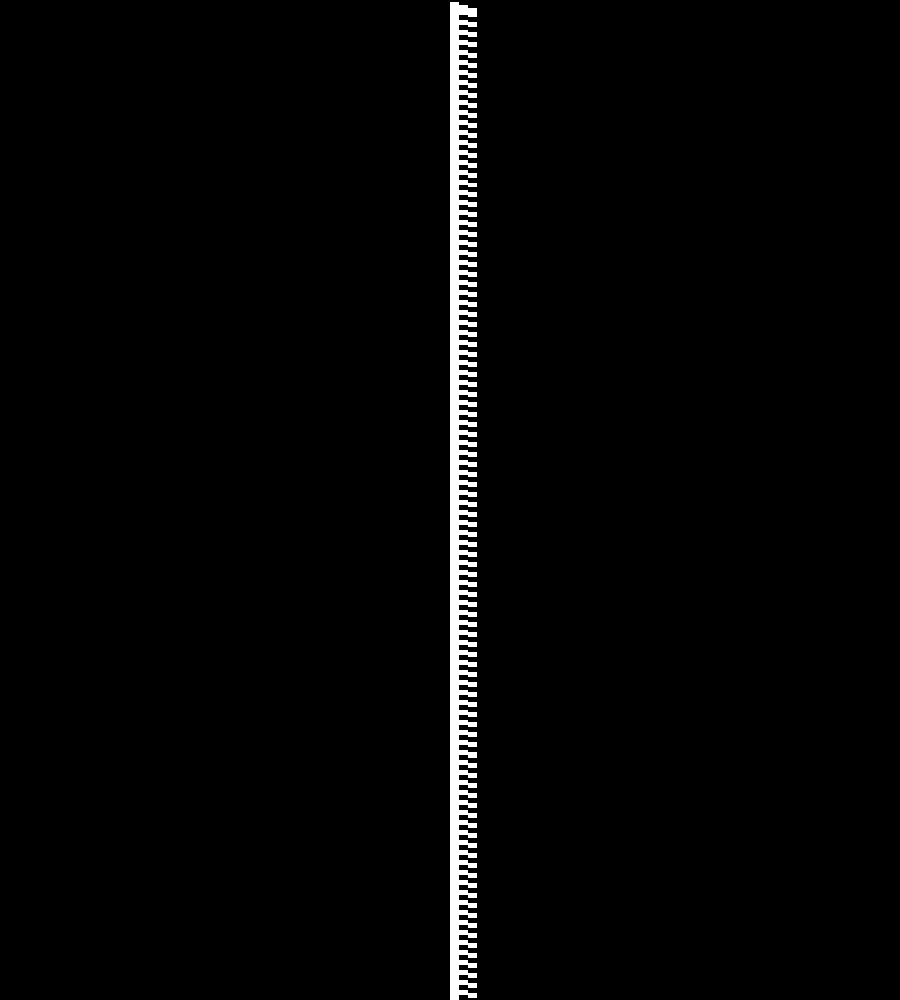

In [52]:
n_list = [11636047, 4231819, 279081]
n = random.choice(n_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Translated Cyclers

**Update 29/01/22**. 73 857 622 translated-cyclers were decided (among machines that exceeded space limit) thanks to the translated-cyclers decider:
[https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-translated-cyclers](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-translated-cyclers).

45010518
s    0    1
---  ---  ---
A    1RB  0RE
B    1RC  1RB
C    1LD  1LE
D    ???  0LB
E    0LB  1RA


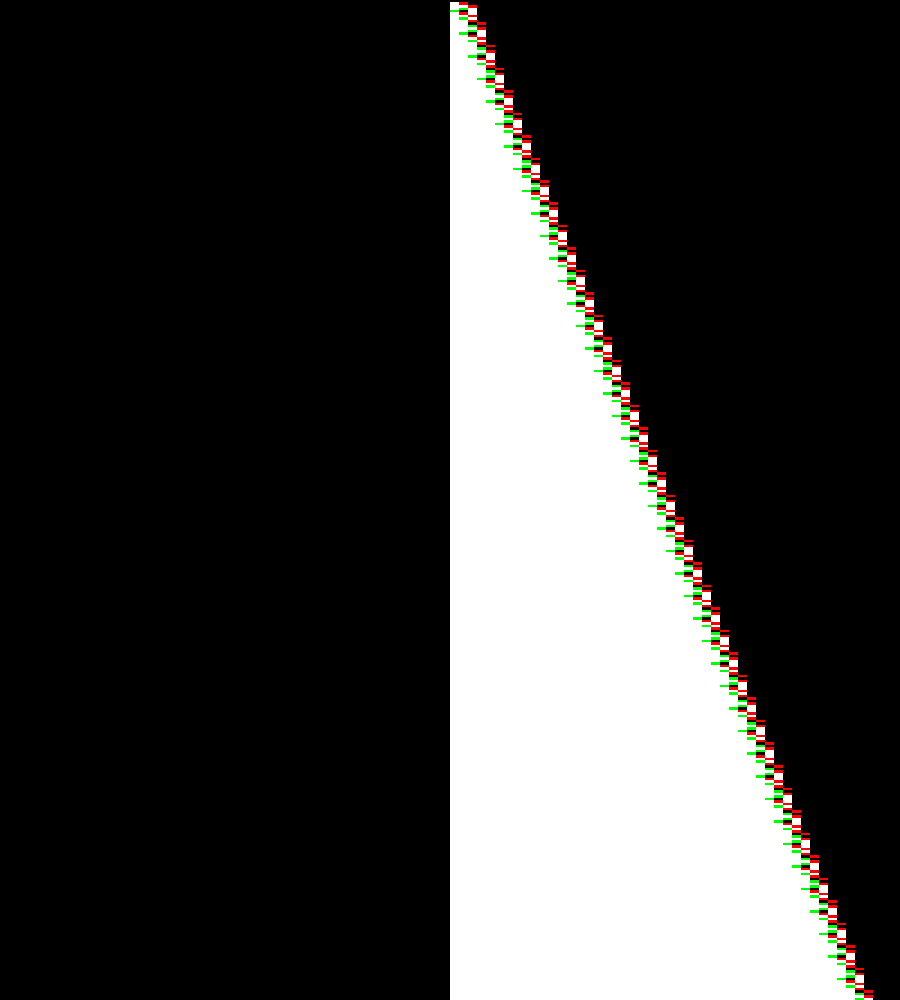

In [53]:
n_list = [32510779, 45010518, 14427007, 14643029, 15167997, 50491158, 59645887, 31141863, 28690248]
n = random.choice(n_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Complex translated cyclers

They are translated cyclers but we discovered them later in a smaller 200k sample remaining of the 88M undecided machines. They were most probably missed by the translated-cyclers decider because they need bigger parameters to be recognised. We will re-run the decider with those higher parameters.

88062418
s    0    1
---  ---  ---
A    1RB  1LE
B    1LC  0RE
C    0LA  0RD
D    ???  1RE
E    1LB  0RB


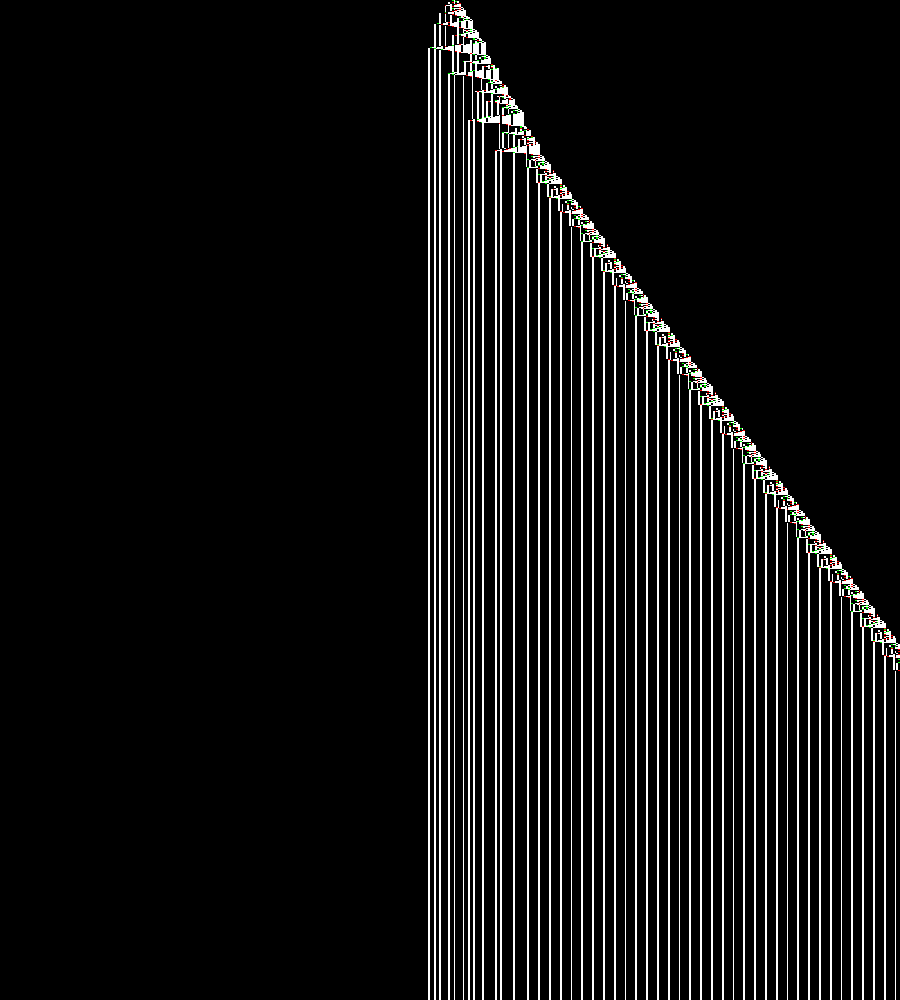

In [54]:
complex_translated_cyclers = [46965866, 74980673, 88062418, 59090563, 76989562, 46546554, 36091834, 58966114]
n = random.choice(complex_translated_cyclers)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=500, height=10000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Unilateral Pongs

846128
s    0    1
---  ---  ---
A    1RB  ???
B    0LC  ???
C    0RE  0LD
D    1LC  1RD
E    1RD  0RB


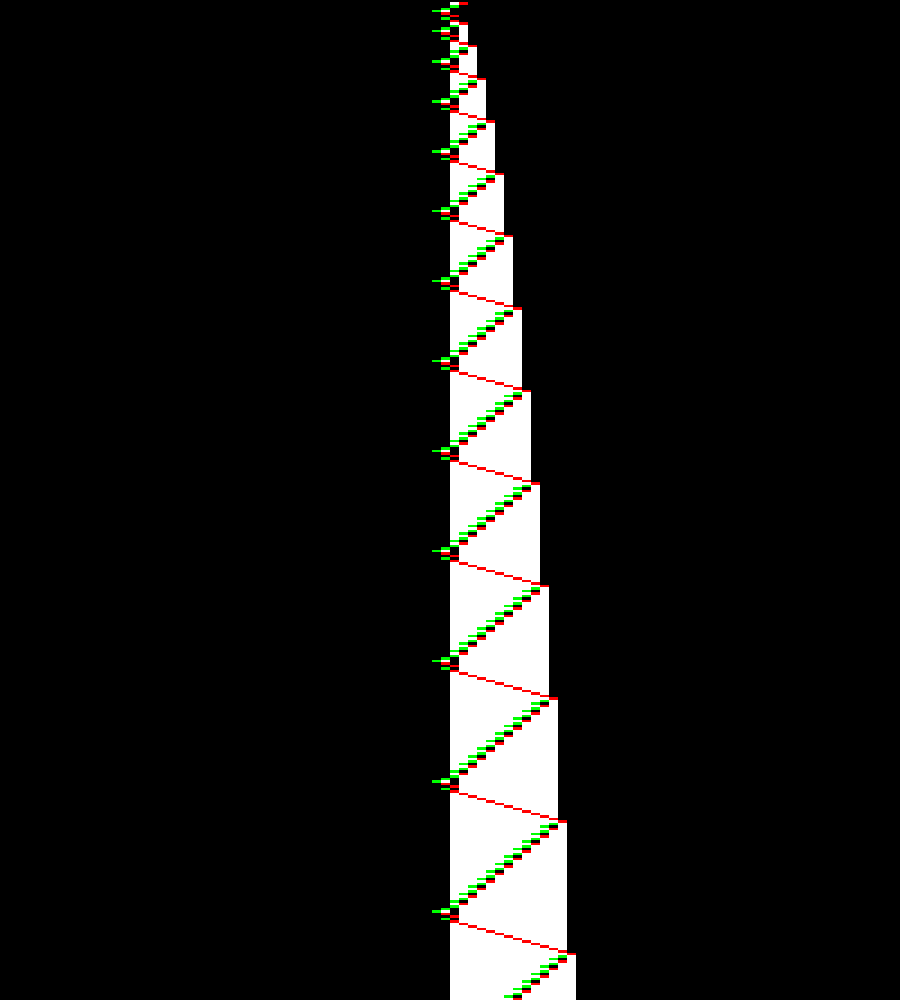

In [55]:
unilateral_pongs_list = [1897885, 524224, 9281450, 8512220, 872367, 13021228, 1288796, 376121, 
                         13781608, 13365152, 3740717, 2683159, 5357965, 12604461, 8541624, 9420847, 
                         7322529, 4830758, 9240606, 12483700, 6411252, 4685904, 1440807, 2107819, 
                         2953298, 11660591, 846128, 12315679, 7704208, 8100160, 3437121, 13410247, 
                         2957273, 11545063, 7865959, 1321388]
n = random.choice(unilateral_pongs_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Translated Unilateral Pongs

83854998
s    0    1
---  ---  ---
A    1RB  1LD
B    1RC  1LA
C    1RD  ???
D    1RE  0LD
E    1LB  0RA


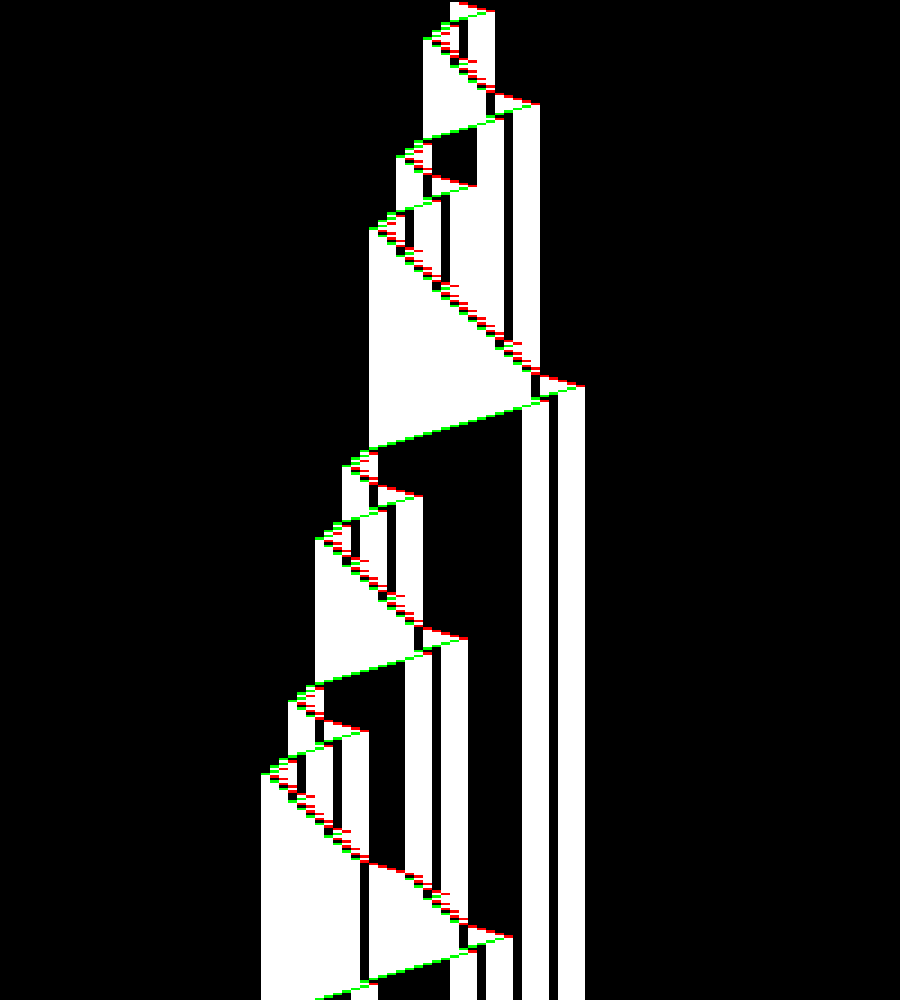

In [56]:
translated_unilateral_pongs_list = [42255, 83854998, 6164147, 11275965, 20076854, 11263544, 6092912, 
                                    12027627, 7728246]
n = random.choice(translated_unilateral_pongs_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Bilateral Pongs

4897489
s    0    1
---  ---  ---
A    1RB  0RD
B    0RC  1RD
C    1LA  ???
D    1LA  1LE
E    1LA  1RB


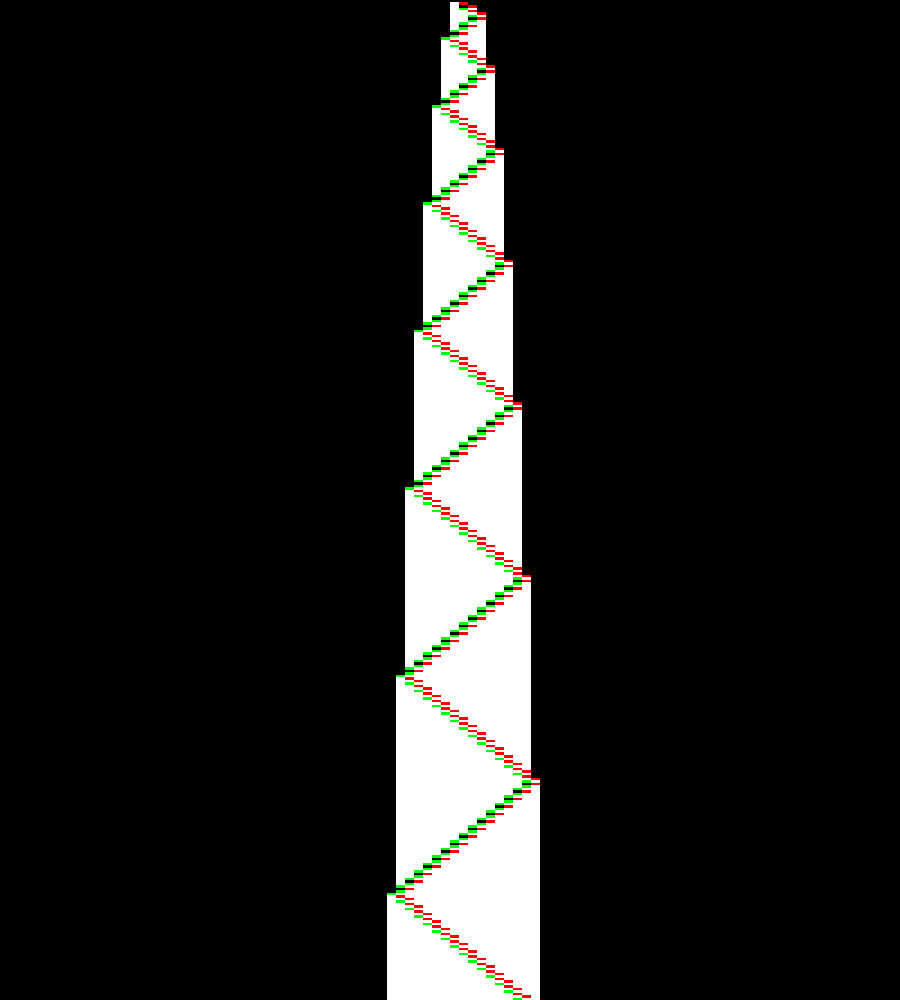

In [57]:
bilateral_pongs_list = [12785688, 8929416, 76727755, 8179149, 8680193, 10955739, 58057, 10784014, 
                        10750857, 82820597, 9627910, 10788462, 2488210, 14155579, 2712075, 5531970, 
                        9099315, 11323181, 1550671, 8631993, 6686258, 3301037, 9357684, 7260722, 
                        12604461, 7083973, 11685160, 14076871, 10879705, 15439564, 167872, 12112369,
                        2815026, 7762990, 9556263, 9660079, 1828616, 10278087, 2163518, 5747101, 
                        10436913, 400772, 626088, 6251627, 965550, 8759155, 11223826, 10753312, 
                        3467845, 4897489, 9003220, 8570030, 11270715, 27293997, 5699889, 9829009, 
                        59839853, 6170236, 11982212, 7164345, 8189825, 12875376, 12764993, 13199370, 
                        2272659, 4789124, 9105362, 12846440, 40562752, 3336092, 9124284, 6283269, 
                        71791981, 8813622, 11319132, 3405717, 7890444, 86152240, 9562099, 11185189, 
                        153481, 10667540, 69838082, 4139167, 11790195, 6283761, 6040629, 2963361, 
                        11341640, 3133305, 6223673, 9129536, 10884143, 35695274, 5253373, 12304289, 
                        3814868, 10866122, 298605, 6345422, 8192282, 4793378]
n = random.choice(bilateral_pongs_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Exponential Counters

2940930
s    0    1
---  ---  ---
A    1RB  ???
B    1LC  0LB
C    0RC  0RD
D    1RE  1LC
E    1LB  1RE


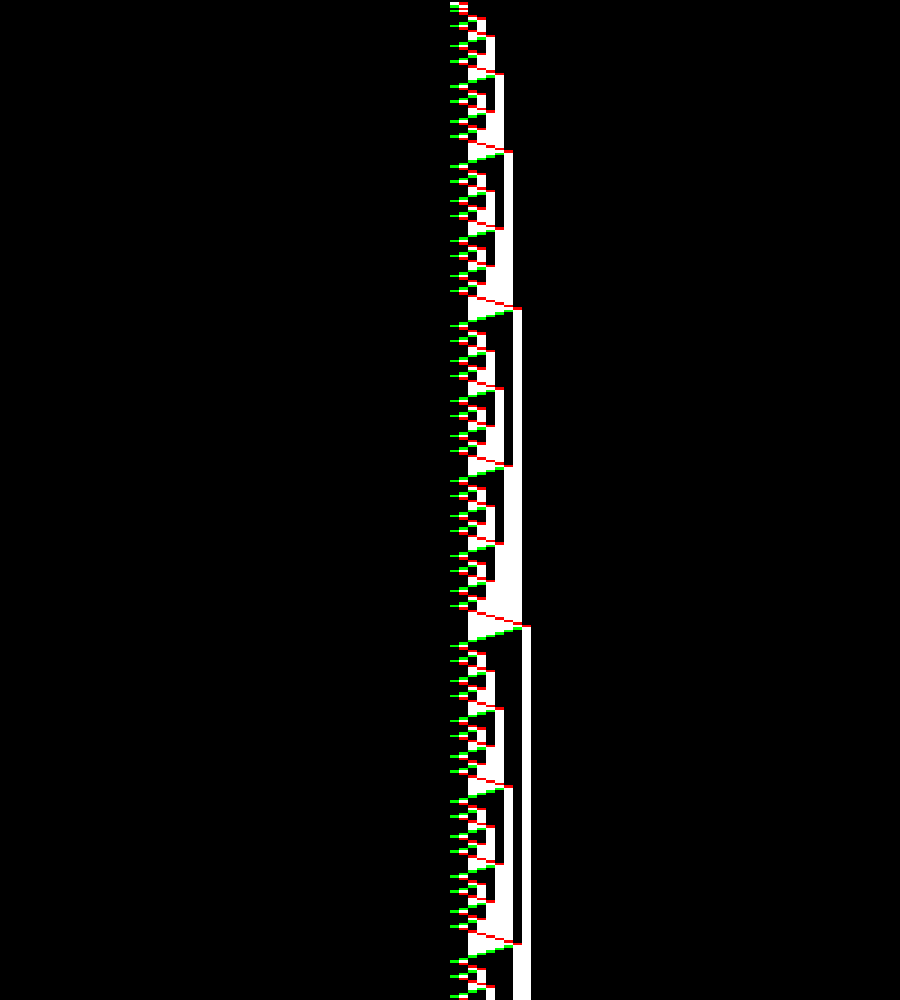

In [58]:
smart_counters = [14244805, 8413822, 2351048, 903500, 2940201, 437775, 10126234, 12012425, 
                  14263231, 6245415, 6776164, 3266856, 2940930, 6486385]
n = random.choice(smart_counters)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Potential Halters

73261028
s    0    1
---  ---  ---
A    1RB  1LA
B    1RC  0LD
C    1LA  1RB
D    1LE  1LB
E    1LA  ???


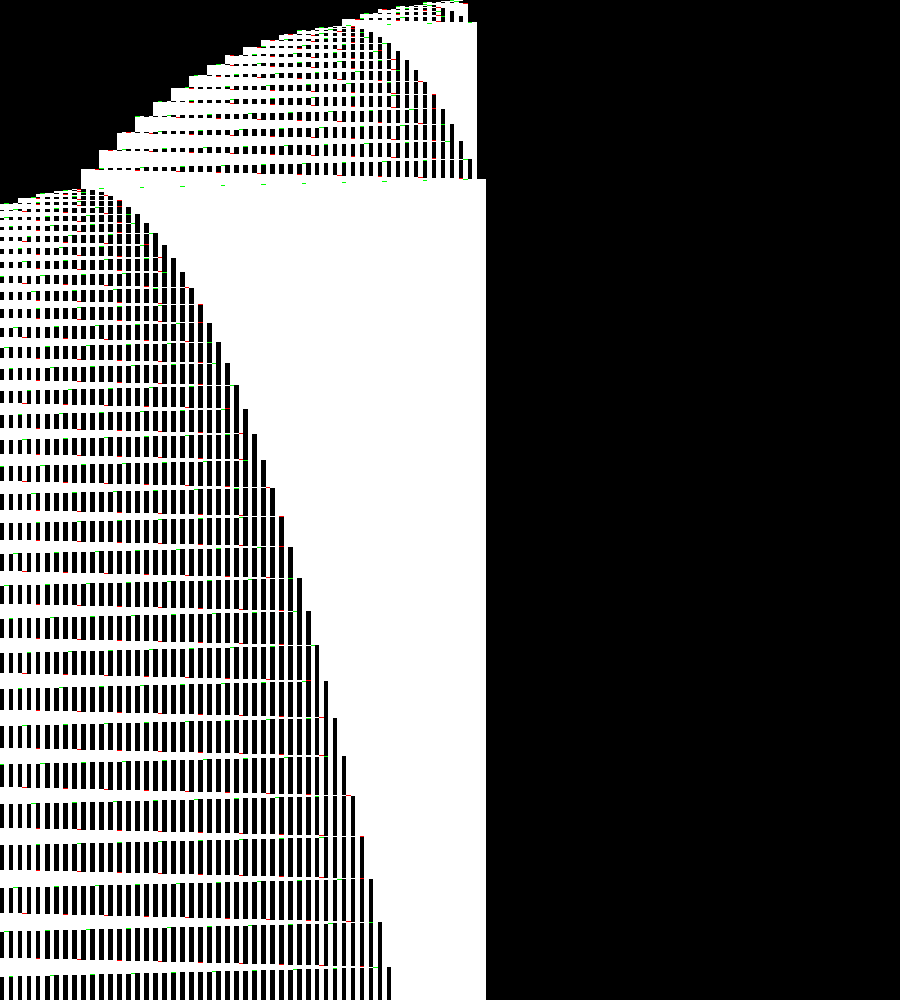

In [59]:
potential_halters_list = [73261028, 58360621, 8527536, 7911681, 28086713, 11059089, 2009846, 11670429, 7865218, 1973992]
# ^ they are all looking a lot like BB5 apart from 13754164 that looks like 20739 steps, 7658575 as well
n = random.choice(potential_halters_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=9000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Not classed yet

9390305


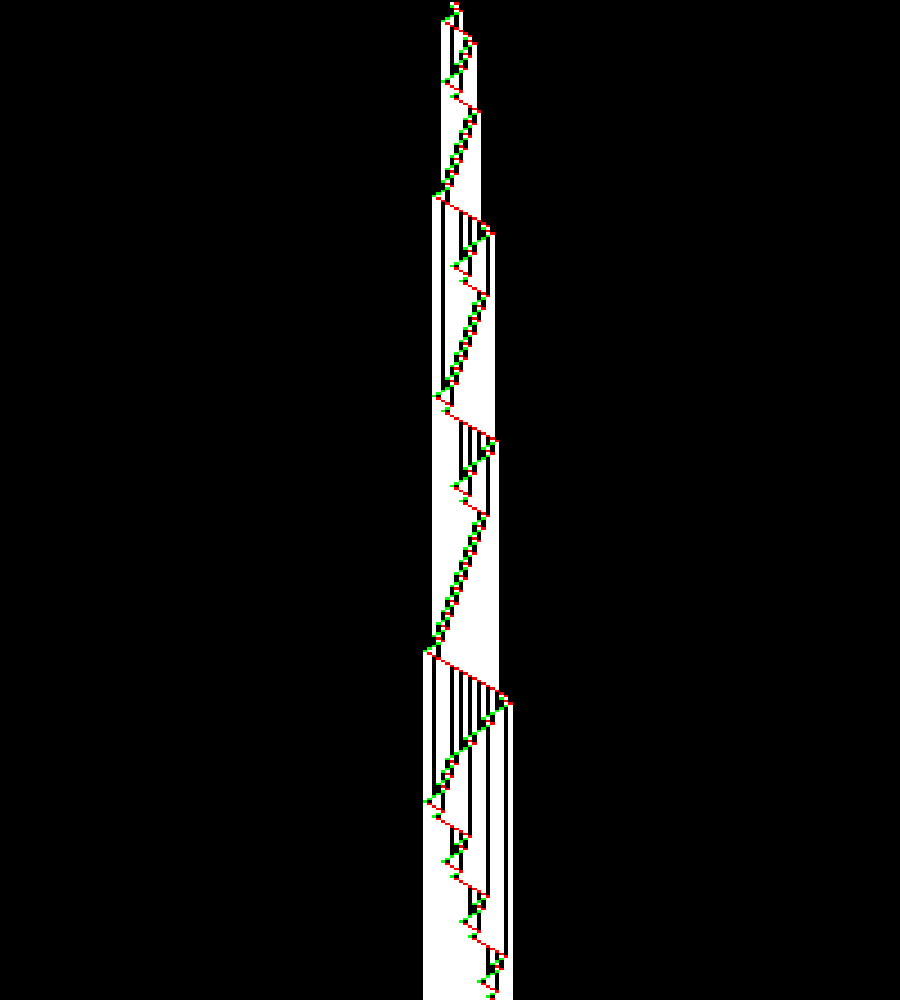

In [60]:
n_list = [2693691, 6490892, 8161712, 4920918, 73261028, 2364441, 5612126, 11274026, 
          2713328, 2394179, 27879939, 9390305, 43374927, 7038828, 42736705, 
          7530230, 7410754, 35201357]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Funny/unrelevant

In [62]:
n_xmas = [6093803, 13099871]
bilateral_binary_counter = 3840180

## Backward Reasoning

Independtly of the behavior of a machine you can sometimes tell that it doesnt halt by simulating it backwards from undefined transitions and realising that it always lead to a contradiction. 

See https://discuss.bbchallenge.org/t/decider-backward-reasoning/35/2

Example:

2009846
s    0    1
---  ---  ---
A    1RB  ???
B    1RC  1RB
C    1LD  0LE
D    0RB  0LC
E    1RE  1RD


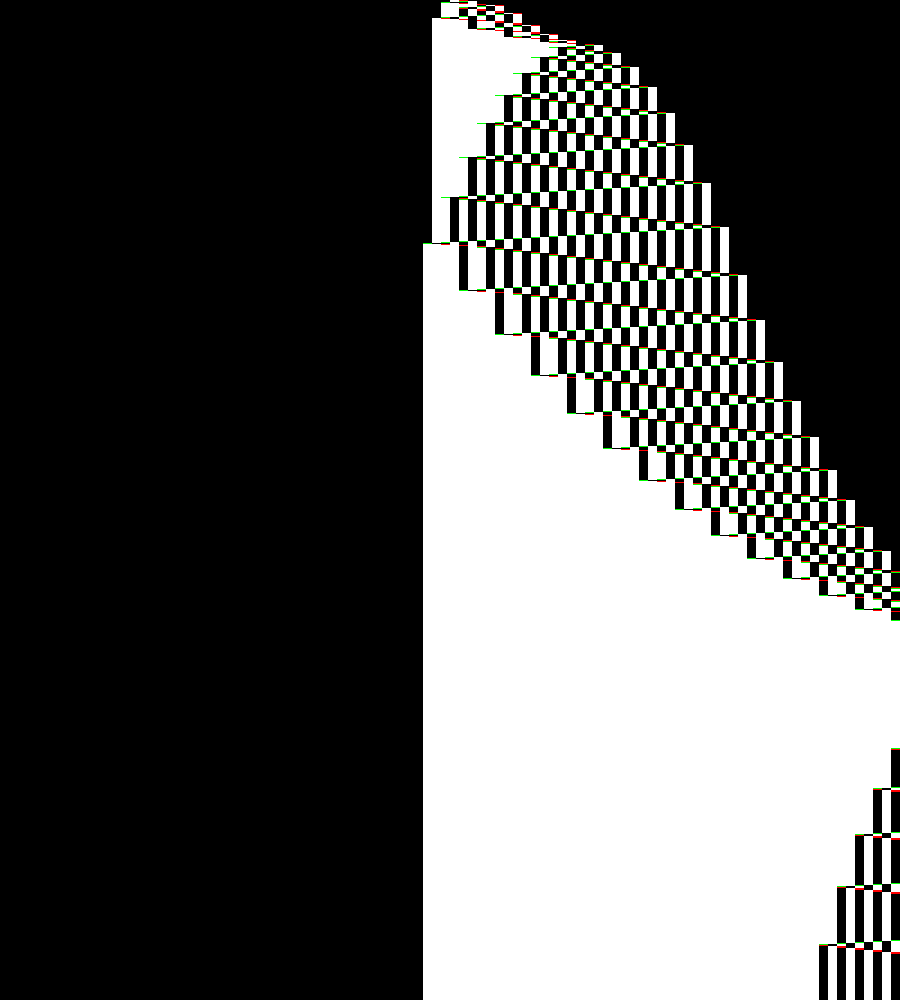

In [63]:
n_backward_reasoning_list = [4843748, 58360621, 2009846, 1973992, 11176971, 4147941, 12071224]
n = random.choice(n_backward_reasoning_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=2000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img